In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import generate_video_with_text, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox

import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
@pims.pipeline
def crop(img, bbox):
    """
    Crop the image to select the region of interest
    """
    xmin, xmax, ymin, ymax = bbox
    return img[ymin:ymax, xmin:xmax]


In [3]:
vid_path = "../data/videos/feature-extraction/"
vid_filename = "2024_0331_091926_007_trimmed.mp4"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = get_video_properties(vid_path, vid_filename)
print(vid_props) # ["filename", "fps", "num_frames", "width", "height"]

# Scale D-high UNCLEAR?????
pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 2) # resample to 30 fps
img_save_dir = f"../data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

# IMAGES
img_filenames = sorted([fn for fn in os.listdir(img_save_dir) if fn.endswith("jpg")])
img_filepaths = [os.path.join(img_save_dir, fn) for fn in img_filenames]

# CREATE! mask filenames based every second image frame exported
masks_dir = f"../data/seg_masks/{vid_filename.split('.')[0]}_masks/"
mask_filenames = sorted([fn for fn in os.listdir(masks_dir) if fn.endswith("png")])
mask_filepaths = [os.path.join(masks_dir, fn) for fn in mask_filenames]

print(len(mask_filepaths), len(img_filepaths))

(60, 685, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61
685 685


In [4]:
# Get contours from masks
contour_list = get_contours_from_segmasks(mask_filepaths)
df_stats = get_contour_stats(contour_list, min_area=2200)

# Add infos to dataframe
df_stats["time"] = df_stats.index.values / fps
df_stats[["img_fp", "mask_fp"]] = pd.DataFrame({'img_fp': img_filepaths, 'mask_fp': mask_filepaths})

# Check corresponding lengths
print(len(contour_list), len(mask_filepaths), len(df_stats))
print("centroid isNaN:", df_stats["centroid_x"].isna().sum())

685 685 685
centroid isNaN: 0


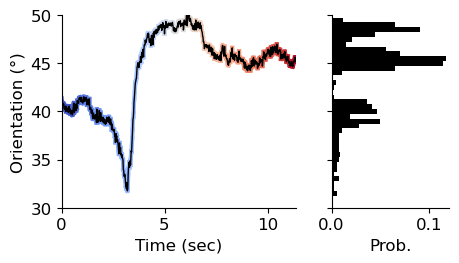

In [5]:
save_path = f"../data/results/egocentric/{vid_filename.split('.')[0]}"
os.makedirs(save_path, exist_ok=True)
SAVE_FIGURES = False

# Get frames and noralized perimeter
variables = ["time", "perimeter", "centroid_dist", "orientation"]
time, perimeter, dcm, orient = df_stats[variables].values.T
nperimeter = perimeter #/ mpp


tc, _ = create_scalarmappable("coolwarm", np.arange(0, len(time)))

fig, ax = plt.subplots(1, 2, figsize=(5,2.5), gridspec_kw={"width_ratios":[2,1]})
plot_colorline(time, orient, colors=tc, ax=ax[0], lw=3)
ax[0].plot(time, orient, "-k", lw=1)
ax[0].set(xlabel="Time (sec)", ylabel="Orientation (°)", xlim=(0, max(time)), ylim=(30,50));

c, bins = np.histogram(orient, bins=np.arange(30,50.2,.5))
ax[1].barh(bins[:-1], c / sum(c), height=.5, color="k");
ax[1].set(xlabel="Prob.", xlim=(0, .12), ylim=(30,50), yticklabels=[]);
fig.savefig(f"{save_path}/orientation_versus_time.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

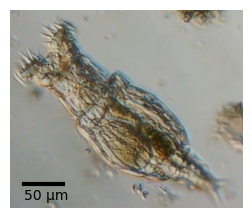

In [6]:
img = cv2.cvtColor(cv2.imread(os.path.join("../data/images/", "frame_00340_bbox_cut.jpeg")), cv2.COLOR_BGR2RGB)
ax_params = dict(xlim=(0, img.shape[1]), ylim=(img.shape[0], 0))

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img)
plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(30,50), linewidth=3, fontsize=10)
ax.set(**ax_params); ax.axis("off"); ax.invert_yaxis()
fig.savefig(f"{save_path}/Illustration_frame00340.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

In [7]:
# setup params
centers = list(df_stats.loc[:, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
rot_angles = df_stats["orientation"].values # np.ones_like(df_stats["orientation"].values) * 45
masks_illustrate = df_stats["mask_fp"].to_list()

# operate on masks and contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, masks_illustrate)
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
norm_centers = list(df_top_bot[["top_x", "top_y"]].itertuples(index=False, name=None))

centered_contours = normalize_contours_by_centers(rot_contours, centers) 
norm_contours = normalize_contours_by_centers(rot_contours, norm_centers) 


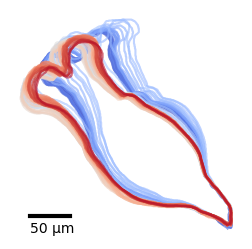

In [8]:
every_nth = 10
subcontours = contour_list[::every_nth]
tcolors, _ = create_scalarmappable("coolwarm", range(len(subcontours)), (0, len(subcontours)))

fig, ax = plt.subplots(figsize=(3,3))
for nth, rcnt in enumerate(subcontours):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-", lw=1.5, alpha=.6, color=tcolors[nth])

plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(1170,180), linewidth=3, fontsize=10)
ax.set_aspect("equal"); ax.set_axis_off()
fig.savefig(f"{save_path}/Contour-overlay_time_color_code.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

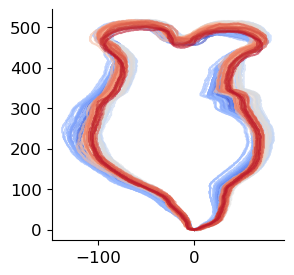

In [9]:
subcontours = norm_contours[::every_nth]
tcolors, _ = create_scalarmappable("coolwarm", range(len(subcontours)), (0, len(subcontours)))

# Plot
fig, ax = plt.subplots(figsize=(3,3))
for nth, rcnt in enumerate(subcontours):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-", lw=1.5, alpha=.6, color=tcolors[nth])

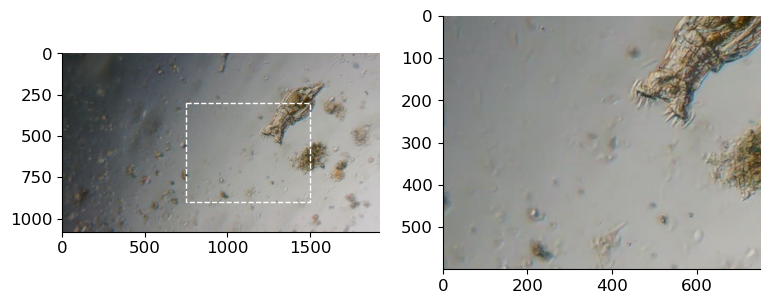

In [16]:
oimg = cv2.cvtColor(cv2.imread(df_stats.loc[0, "img_fp"]), cv2.COLOR_BGR2RGB)

ccenter = (1250, 500) # corona center
xoffset = (500, 500/2)
yoffset = (200, 400)
xmin, xmax = int(ccenter[0]-xoffset[0]), int(ccenter[0]+xoffset[1])
ymin, ymax = int(ccenter[1]-yoffset[0]), int(ccenter[1]+yoffset[1])
bbox = [xmin, xmax, ymin, ymax]
cut_width, cut_height = xmax-xmin, ymax-ymin 

fig, ax = plt.subplots(1,2,figsize=(9,6))
ax[0].imshow(oimg)
ax[1].imshow(oimg[ymin:ymax, xmin:xmax])
plot_bbox(bbox, ax=ax[0])
#ax.set(**ax_params);


# Corona Video

In [11]:
# write video function
SAVE_VIDEO = False
video_save_fpath = f"../data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

img_fp = df_stats["img_fp"].tolist()
bbox = [xmin, xmax, ymin, ymax]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)

generate_video_with_text(vid_params, img_fp, text_params, bbox) if SAVE_VIDEO else None

# Particle tracking

In [18]:
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
import trackpy as tp

# POTENTIALLY Scale D-mid
# pixel_per_real_width = .75
# mpp = 1.333  # microns_per_pixel
# print("D MID - FHD, pixel_per_real_width = ", pixel_per_real_width)

In [19]:
# Read-in
img_seq_folder = f"{img_save_dir}/*.jpg"
frames = pims.as_grey(crop(pims.open(img_seq_folder), bbox))

img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))


real width (µm):  454.55 
real height (µm): 363.64


n features -  68
rotifer 23 
detrituts 14


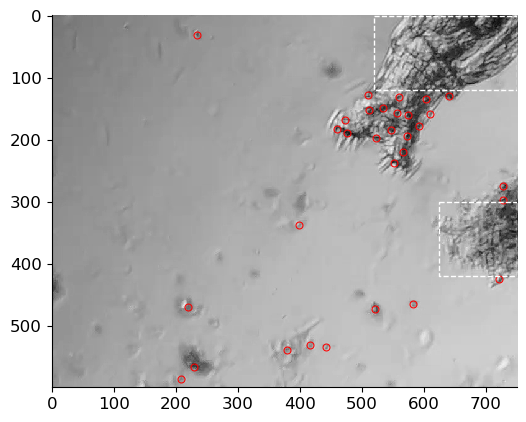

In [84]:
locate_params = {
    "diameter" : 17,
    "threshold" : 9,
    "invert" : True,
}
frame_nr = 1
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# # Rotifer exclude
rotifer_bbox = [520, img_width, 0, 120,]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]

# Detritus exclude
detritus_bbox = [625, img_width, 300, 420]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]

print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))

fig, ax = plt.subplots()
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

# # BBoxes to exclude
plot_bbox(rotifer_bbox)
plot_bbox(detritus_bbox)

In [85]:
tp.quiet()
fbatch = tp.batch(frames, **locate_params)

# lower_condition = (fbatch.y < 100) & (fbatch.x > 570)
# fbatch = fbatch[~lower_condition]

rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
fbatch = fbatch[~rotifer_condition]

detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
fbatch = fbatch[~detritus_condition]

print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))
fbatch


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
4,32.139505,235.717949,839.688861,2.276803,0.055278,42.696044,-25799.0113,0.201542,0
22,128.193458,510.067074,2208.881651,4.730556,0.498087,47.075125,-24055.2009,0.143867,0
23,130.448501,559.022161,1729.007312,3.953241,0.565017,48.534819,-25687.6347,0.196510,0
24,130.441645,640.468723,2910.994371,4.399505,0.261297,50.359436,-19777.8084,0.084532,0
25,133.951726,602.950263,1247.308357,4.579095,0.325800,31.748340,-17835.2663,0.071196,0
...,...,...,...,...,...,...,...,...,...
44895,508.091342,261.657542,1254.736544,2.867914,0.260768,42.185430,-29008.3027,0.749682,684
44896,528.962021,416.748956,982.957846,3.559862,0.388916,24.639278,-31616.2823,-0.614987,684
44897,533.315670,355.157265,655.180790,2.741056,0.323803,22.399343,-31431.1727,-0.706235,684
44898,538.314872,379.507359,963.918404,3.800047,0.357946,25.759245,-28433.0780,0.503333,684


In [86]:
link_params = {
    "search_range" : 50,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/6); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 1016
10
N Before: 1016 
 N after filtering: 388


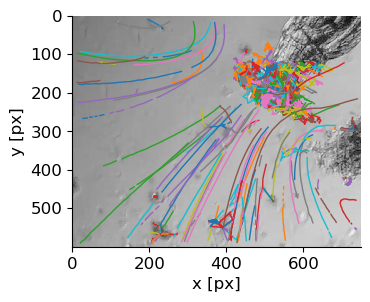

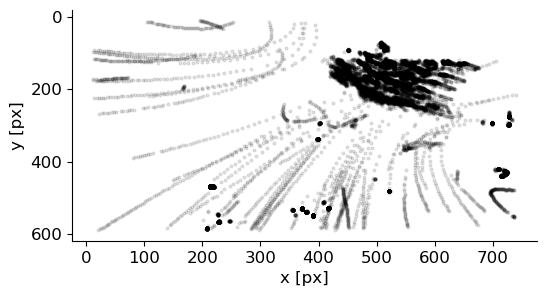

In [122]:
# This plots trajectories with associated particle number
fig, ax = plt.subplots()
tp.plot_traj(trajs, superimpose=frames[frame_nr], label=False, ax=ax);#, label=True

fig, ax = plt.subplots()
tp.scatter(trajs, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"});
#ax.set(**ax_params); ax.invert_yaxis(); ax.invert_xaxis()

In [94]:
stats, frames_present = get_trajectory_stats(trajs);

# Spatial filtering of trajectories
# to_drop = stats.loc[(stats["x_avg"] > 520) & (stats["y_avg"] < 150), "particle"].to_list()
# trajs_ = trajs[~trajs['particle'].isin(to_drop)]

# Re-Calculate stats and reject more based on std of spatial position
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 20) & (stats.y_std < 30)  #reject_idx = (stats.x_std < 20) | (stats.y_std < 20)
reject_prts = stats.particle[reject_idx].to_numpy()  #reject_prts = np.append(reject_prts, [56, 81]) 

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
#num_filtered_particles = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
num_particles_rejected = traj_rejected.particle.nunique()
print("number of particles (original):", num_ori_particles, #"\nnumber of filtered particles:", num_filtered_particles,
      "\nnumber of rejected particles:", num_particles_rejected, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj)
print(len(stats))

number of particles = number of trajectories: 388
number of particles = number of trajectories: 388
number of particles (original): 388 
number of rejected particles: 322 
number of particles remaining: 66
number of particles = number of trajectories: 66
66


/Users/mikehemberger/opt/miniconda3/lib/python3.9/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


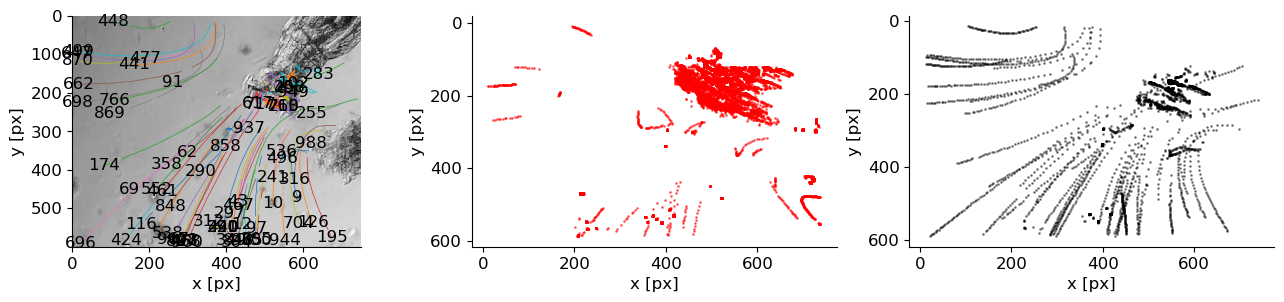

In [95]:
fig, ax = plt.subplots(1,3, figsize=(16, 3))
tp.plot_traj(ctraj, superimpose=frames[0], label=True, ax=ax[0], plot_style={"lw" : .5}); #ax[0].set(**ax_params); 

#tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});
tp.scatter(traj_rejected, ax=ax[1], plot_style={"ms" : 1, "alpha" : .5, "color" : "r", "label" : "rejected"})
#ax[1].set(**ax_params); ax[1].invert_yaxis(); ax[1].invert_xaxis(); ax[1].legend()

tp.scatter(ctraj, ax=ax[2], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});
#ax[2].set(**ax_params); ax[2].invert_yaxis(); ax[2].invert_xaxis()

In [115]:
displacement_array = reindex_calculate_displacement_and_stack(ctraj, np.arange(0, len(frames)))
displacement_array = (displacement_array)
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)
df_disp

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.721298,13.077875,6.876416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.988346,15.146721,8.164227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.468421,12.112066,7.803802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.107585,13.057012,7.797379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.428466,0.260488,NaN,NaN,19.052886,7.604932,5.950114
681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.563260,0.124237,NaN,NaN,20.953463,7.604932,NaN
682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.937483,0.605483,NaN,NaN,23.215822,7.604932,NaN
683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.449883,0.247828,NaN,NaN,23.451065,NaN,NaN


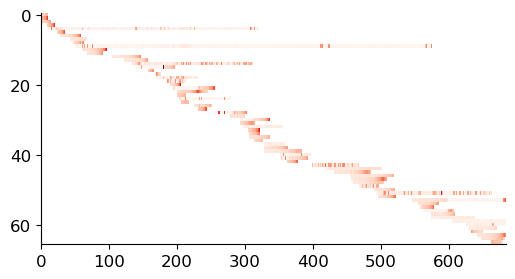

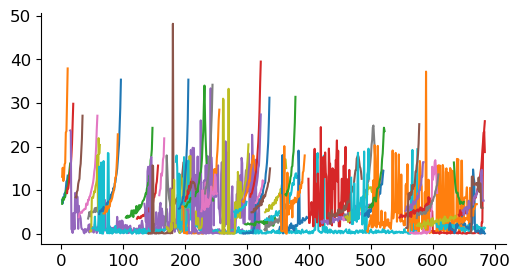

In [118]:
plt.subplots()
plt.imshow(df_disp.values.T, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=np.nanmax(df_disp.values))#, extent=[0, fr_time[-1], displacement_array.shape[0], 0]
#displacement_array
plt.subplots()
plt.plot(df_disp.values); # displacement_array.T

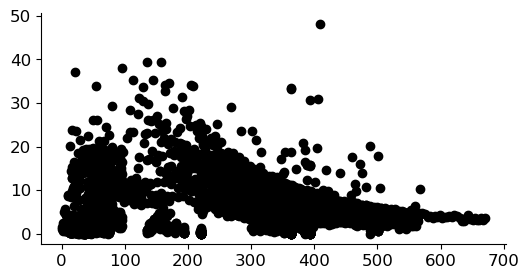

In [98]:
# df = pd.DataFrame()
# particles = ctraj.particle.unique()
# for nth in particles:
#     traj = ctraj.loc[ctraj["particle"] == nth]
#     d = {
#         "x" : traj.x.to_list(),
#         "y" : traj.y.to_list(),
#         "dx" : traj.x.diff().to_list(),
#         "dy" : traj.y.diff().to_list()
#     }
#     df_loop = pd.DataFrame(d)
#     df = pd.concat([df, df_loop[1:]])

# points = df[["x", "y"]].to_numpy()
# velocities = df[["dx", "dy"]].to_numpy()
# v_xy = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) #* fps / mpp

# corona_center = (570, 200)
# #ctraj["rdist"] = np.sqrt((ctraj.x - corona_center[0]) ** 2 + (ctraj.y - corona_center[1]) ** 2)  # radial distance
# df["rdist"] = np.sqrt((df.x - corona_center[0]) ** 2 + (df.y - corona_center[1]) ** 2)  # radial distance
# df["v"] = v_xy

# plt.plot(df.rdist, df.v, "ok")

In [119]:
corona_center = (570, 200)

func = lambda i: i.diff()
# Calculate the differences in x and y positions, and time using transform
ctraj['dx'] = ctraj.groupby('particle')['x'].transform(func)
ctraj['dy'] = ctraj.groupby('particle')['y'].transform(func)
ctraj['velocity'] = np.sqrt(ctraj['dx']**2 + ctraj['dy']**2)# / df['frame_diff']
ctraj['rdist'] = np.sqrt((ctraj['x'] - corona_center[0]) **2 + (ctraj['y'] - corona_center[1]) **2)
bins = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), 30)
ctraj['rbin'] = pd.cut(ctraj['rdist'], bins)
ctraj_ = ctraj.dropna()
bin_stats = ctraj_.groupby('rbin', observed=True)['velocity'].agg(['mean', 'std', 'count'])
bin_centers = [round(interval.mid, 1) for interval in bin_stats.index.categories]


In [120]:
n_frames = ctraj_.groupby('particle')['frame'].count()
n_frames.sort_values(ascending=False)

particle
102    511
49     299
760    144
213    139
827    125
      ... 
43      11
10      10
9       10
255      9
241      9
Name: frame, Length: 66, dtype: int64

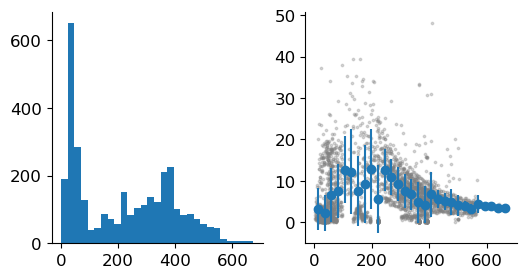

In [121]:
fig, ax = plt.subplots(1,2)
ax[0].bar(bin_centers, bin_stats['count'].values, width=np.diff(bins)[0])

ax[1].errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'], fmt='o', label='Average Velocity')
ax[1].scatter(ctraj_['rdist'], ctraj_['velocity'], alpha=0.3, color='gray', s=3, label='Individual Velocities')


# Image based capture explore

noteable frames:
start with lower interframe numbers so to check whether it works
- 57-82
- 91-132
- 201-242, handled and rejected, but rotifer movement
- 237-322, multiple catch events, first ones 237-285
- 333-360
- 366-411
- 498-544
- 629-664

In [ ]:
img_seq_folder = f"{img_save_dir}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))

# framew = (57,82)
# pre = np.arange(52,56)
# normed_frame = frames[np.arange(59,61)][ymin:ymax, xmin:xmax] - np.mean(np.stack(frames[pre], axis=-1), axis=-1)[ymin:ymax, xmin:xmax]
# print(np.min(normed_frame), np.max(normed_frame), np.percentile(normed_frame, [5, 95]))
# plt.imshow(normed_frame, cmap="gray")

frame_windows = [(57,82), (91,132), (201,242), (237,322), (333,360), (366,411), (498,544), (629,664)];  # cut = 10
stacked_norm = []

for framew in frame_windows:
    n_frames = np.diff(framew)
    window_indices = np.arange(framew[0], framew[1], 1)
    avg_pre = np.mean(np.stack(frames[window_indices[0]-5:window_indices[0]], axis=-1), axis=-1)[ymin:ymax, xmin:xmax]
    zprojs = []
    for wi in window_indices:
        
        stacked = np.stack(frames[wi][ymin:ymax, xmin:xmax]) - avg_pre #frames[window_indices[0]][ymin:ymax, xmin:xmax]
        zprojs.append(stacked); #print(stacked.shape)

    stacked = np.stack(zprojs, axis=-1); del zprojs
    norm_stack = np.min(stacked, axis=-1)  # #norm_stack = np.mean(np.diff(stacked, axis=-1), axis=-1)
    stacked_norm.append(norm_stack)
    
    plt.figure(figsize=(10,10))
    plt.imshow(norm_stack, cmap="gray")
    plt.title(f"frames {framew}, n={n_frames}")


plt.figure(figsize=(10,10))
plt.imshow(np.mean(np.stack(stacked_norm, axis=-1) ,axis=-1), cmap="gray")
plt.title(f"frames {framew}, n={n_frames}")


# temporal cut to RGB image

In [ ]:
# cuts = [[38, 41.5], [43.5, 47], [47.75, 51]]
# indices = []
# for cut in cuts:
#     indices.append(df_stats[df_stats["orientation"].between(cut[0], cut[1])].index.values)
#     print(len(indices[-1]))

# ccolor = ["r", "b", "k"]
# fig, ax = plt.subplots(figsize=(3,3))
# for inds, c in zip(indices, ccolor):
#     for nth, ind in enumerate(inds[::2]):
#         rcnt = contour_list[ind]
#         x,y = rcnt.squeeze().T
#         ax.plot(x, y, "-", lw=1, alpha=.4, color=c)

# img_seq_folder = f"{img_save_dir}/*.jpg"
# frames = pims.as_grey(pims.open(img_seq_folder))
# avg = np.mean(frames[1,3,6], axis=-1)

# zprojs = []
# for nth in range(3):
#     stacked = np.stack(frames[indices[nth]]) - frames[indices[nth][0]]
#     print(stacked.shape)
#     zprojs.append(np.min(stacked, axis=0))

# for zproj in zprojs:
#     plt.figure()
#     plt.imshow(zproj, "Reds_r")
    
# norm_zprojs = [1 - (proj - np.min(proj)) / (np.max(proj) - np.min(proj)) for proj in zprojs]

# # RGB stack
# rgb = np.stack(norm_zprojs, axis=-1)
# plt.figure(figsize=(9,9))
# plt.imshow(rgb)
# plt.gca().invert_yaxis()

# plt.figure(figsize=(9,9))
# plt.imshow(rgb)
# plt.xlim(900,1500); plt.ylim(300, 900)